#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite Difference methods in 2 dimensions

Let's start by generalizing the 1D Laplacian,

\begin{align} - u''(x) &= f(x) \text{ on } \Omega = (a,b) & u(a) &= g_0(a) & u'(b) = g_1(b) \end{align}

to two dimensions

\begin{align} -\nabla\cdot \big( \nabla u(x,y) \big) &= f(x,y) \text{ on } \Omega \subset \mathbb R^2
& u|_{\Gamma_D} &= g_0(x,y) & \nabla u \cdot \hat n|_{\Gamma_N} &= g_1(x,y)
\end{align}

where $\Omega$ is some well-connected open set (we will assume simply connected) and the Dirichlet boundary $\Gamma_D \subset \partial \Omega$ is nonempty.

We need to choose a system for specifying the domain $\Omega$ and ordering degrees of freedom.  Perhaps the most significant limitation of finite difference methods is that this specification is messy for complicated domains.  We will choose
$$ \Omega = (0, 1) \times (0, 1) $$
and
\begin{align} (x, y)_{im+j} &= (i h, j h) & h &= 1/(m-1) & i,j \in \{0, 1, \dotsc, m-1 \} .
\end{align}

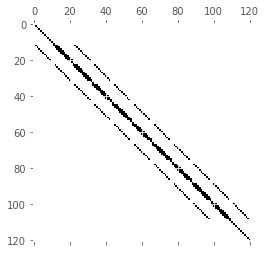

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def laplacian2d_dense(h, f, g0):
    m = int(1/h + 1)
    c = numpy.linspace(0, 1, m)
    x, y = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = numpy.zeros((m*m, m*m))
    def idx(i, j):
        return i*m + j
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            if i in (0, m-1) or j in (0, m-1):
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                cols = [idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]]
                stencil = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
                A[row, cols] = stencil
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_dense(.1, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);

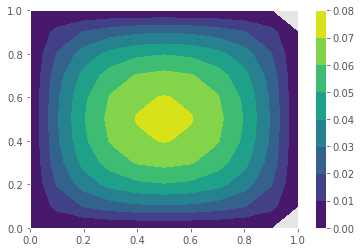

In [2]:
u = numpy.linalg.solve(A, rhs).reshape(x.shape)

pyplot.contourf(x, y, u)
pyplot.colorbar();

In [3]:
import cProfile
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d_dense(.02, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = numpy.linalg.solve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         19525 function calls in 0.256 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.230    0.230    0.230    0.230 linalg.py:300(solve)
        1    0.018    0.018    0.026    0.026 <ipython-input-1-ad069d7c8741>:6(laplacian2d_dense)
     2411    0.003    0.000    0.003    0.000 {built-in method numpy.core.multiarray.array}
     2401    0.003    0.000    0.004    0.000 <ipython-input-1-ad069d7c8741>:22(<listcomp>)
    14606    0.002    0.000    0.002    0.000 <ipython-input-1-ad069d7c8741>:13(idx)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.arange}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.001    0.001 function_base.py:25(linspace)
        3    0.000    0.000    0.256    0.085 interactiveshell.py:2851(run_code)
        2    0.000    0.000    0.000    0.000 stride_tricks.py:115(_broadcast_to)
   

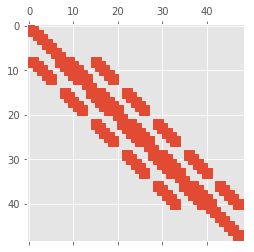

In [4]:
import scipy.sparse as sp
import scipy.sparse.linalg

def laplacian2d(h, f, g0):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    x, y = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = sp.lil_matrix((m*m, m*m))
    def idx(i, j):
        return i*m + j
    mask = numpy.zeros_like(x, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
            if mask[row] == 0: # Dirichlet boundary
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                cols = stencili #[smask == 1]
                A[row, cols] = stencilw #[smask == 1]
                # bdycols = stencili[smask == 0]
                # rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    return x, y, A.tocsr(), rhs

x, y, A, rhs = laplacian2d(.15, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);

In [5]:
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d(.003, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         14907121 function calls in 13.470 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   440898    2.193    0.000    2.992    0.000 stride_tricks.py:115(_broadcast_to)
        1    1.197    1.197   12.281   12.281 <ipython-input-4-a018c2030449>:4(laplacian2d)
        1    1.161    1.161    1.161    1.161 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
  1435601    0.929    0.000    0.929    0.000 {built-in method numpy.core.multiarray.array}
   110224    0.759    0.000    0.759    0.000 {scipy.sparse._csparsetools.lil_fancy_set}
   111556    0.715    0.000   10.194    0.000 lil.py:333(__setitem__)
   220449    0.636    0.000    4.765    0.000 stride_tricks.py:195(broadcast_arrays)
   220448    0.485    0.000    1.000    0.000 sputils.py:331(_check_boolean)
   110224    0.473    0.000    4.577    0.000 sputils.py:351(_index_to_arrays)
   220449    0.443    0.000    0.471    0.000 stride_tricks.py:176(_broadca

## A manufactured solution

(51, 51) 1.15397307719e-06


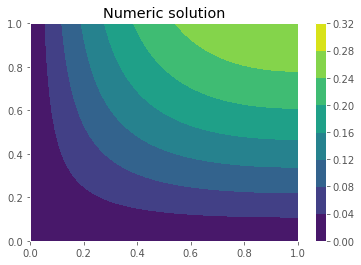

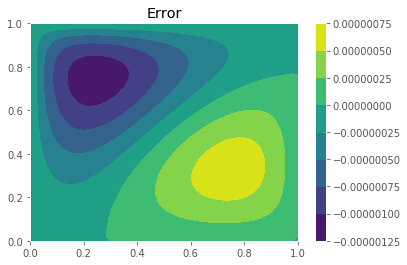

In [6]:
class mms0:
    def u(x, y):
        return x*numpy.exp(-x)*numpy.tanh(y)
    def grad_u(x, y):
        return numpy.array([(1 - x)*numpy.exp(-x)*numpy.tanh(y),
                            x*numpy.exp(-x)*(1 - numpy.tanh(y)**2)])
    def laplacian_u(x, y):
        return ((2 - x)*numpy.exp(-x)*numpy.tanh(y)
                - 2*x*numpy.exp(-x)*(numpy.tanh(y)**2 - 1)*numpy.tanh(y))
    def grad_u_dot_normal(x, y, n):
        grad_u(x, y) @ n

x, y, A, rhs = laplacian2d(.02, mms0.laplacian_u, mms0.u)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(u.shape, numpy.linalg.norm((u - mms0.u(x,y)).flatten(), numpy.inf))
pyplot.contourf(x, y, u)
pyplot.colorbar()
pyplot.title('Numeric solution')
pyplot.figure()
pyplot.contourf(x, y, u - mms0.u(x, y))
pyplot.colorbar()
pyplot.title('Error');

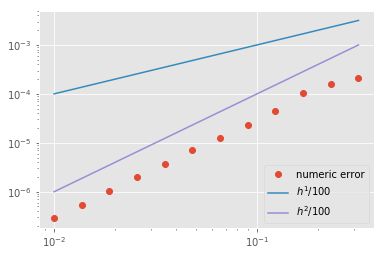

In [7]:
hs = numpy.logspace(-2, -.5, 12)
def mms_error(h):
    x, y, A, rhs = laplacian2d(h, mms0.laplacian_u, mms0.u)
    u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
    return numpy.linalg.norm((u - mms0.u(x, y)).flatten(), numpy.inf)

pyplot.loglog(hs, [mms_error(h) for h in hs], 'o', label='numeric error')
pyplot.loglog(hs, hs**1/100, label='$h^1/100$')
pyplot.loglog(hs, hs**2/100, label='$h^2/100$')
pyplot.legend();